In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

plt.ion()

In [3]:
landmarks_frame = pd.read_csv('/home/bigtree/PycharmProjects/torchloop/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('image is {}'.format(img_name))
print('landmarks shape {}'.format(landmarks.shape))
print('first 4 landmarks are {}'.format(landmarks[:4]))

image is person-7.jpg
landmarks shape (68, 2)
first 4 landmarks are [[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


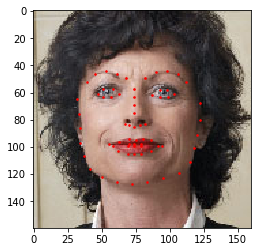

In [4]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 10,
               marker='.', c='r')
    plt.pause(0.001)
plt.figure()
show_landmarks(io.imread(os.path.join(\
               "/home/bigtree/PycharmProjects/torchloop/faces/", 
               img_name)),
               landmarks)
plt.show()

In [5]:
class FaceLandmarksDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, 
                               self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        return sample


0 (324, 215, 3) (68, 2)


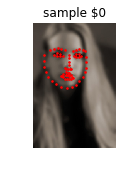

1 (500, 333, 3) (68, 2)


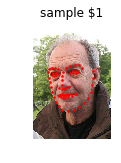

2 (250, 258, 3) (68, 2)


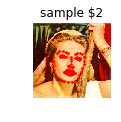

3 (434, 290, 3) (68, 2)


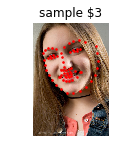

In [6]:
faces_dir = "/home/bigtree/PycharmProjects/torchloop/faces/"
face_dataset = FaceLandmarksDataset(csv_file=os.path.join(faces_dir, "face_landmarks.csv"),
                                   root_dir = faces_dir)
fig = plt.figure()

for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('sample ${}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break

In [7]:
# One issue we can see from the above is that the samples are not of the same size. Most neural networks expect the images of a fixed size. Therefore, we will need to write some prepocessing code. Let’s create three transforms:

# - Rescale: to scale the image
# - RandomCrop: to crop from image randomly. This is data augmentation.
# - ToTensor: to convert the numpy images to torch images (we need to swap axes).
# tsfm = Transform(params)
# transformed_sample = tsfm(sample)

class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_w, new_h))

        landmarks = landmarks * [new_w / w, new_h / h]
        return {'image': img, 'landmarks': landmarks}

class RandomCrop(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top: top + new_h,
                      left: left + new_w]
        landmarks = landmarks - [left, top]
        return {'image': image, 'landmarks': landmarks}
    
class ToTensor(object):
    '''convert nd arrays into samples'''
    
    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
               'landmarks': torch.from_numpy(landmarks)}
        

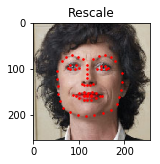

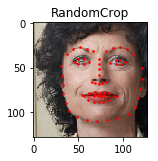

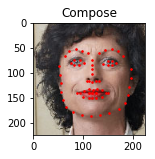

In [11]:
scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256), 
                               RandomCrop(224)])
# apply transform on sample
fig = plt.figure()
sample = face_dataset[65]

for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [ ]:
transformed_dataset = FaceLandmarksDataset(csv_file=os.path.join(faces_dir, "face_landmarks.csv"),
                                          root_dir=faces_dir,
                                          transform=transforms.Compose([
                                              Rescale(256),
                                              RandomCrop(224),
                                              ToTensor()
                                          ]))
for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]